# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

## Due: 2021-10-5

## Name: Samantha Taylor

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [18]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1) 
# PermafrostTemperatureScenarios.csv = file name to be read
# delimiter = string used to separate values
# skiprows = skip the first row of the data file

t_year = data[:,0] # first column of data, 2020-2100
T_15 = data[:,1] # second column of data, scenario 1
T_30 = data[:,2] # third column of data, scenario 2
T_45 = data[:,3] # fourth column of data, scenario 3

Text(0, 0.5, 'Annual average air temperature [°C]')

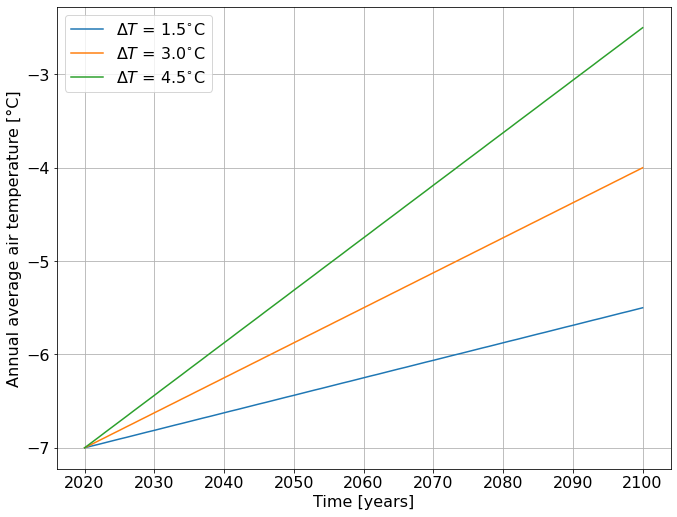

In [19]:
# First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [20]:
# Time properties of simulation
t0 = t_year[0] # this is 2020
tf = t_year[-1] # this if 2100

t = np.arange(t0,tf+(dt/365),(dt/365)) # create an array starting at t0, going to tf+dt/365, with dt/365 step size
Nt = t.size # return the size of t
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [21]:
# Boundary conditions
Ttopamp = 35.0 # amplitude of temperature sinusoidal flutuation [degrees C]
Tbottom = -7.0 # temperature at bottom of column [degrees C]

Ttopbase = -7.0

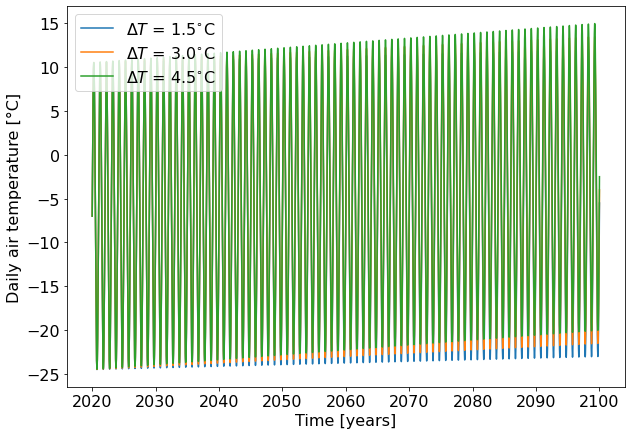

In [22]:
# two key assumptions:
# bottom of boundary is still fixed at -7 degrees C
# annual amplitude of temperature remains the same

# use interpolated values to create temperature sinusoidal forcing terms for all three scenarios
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

# plot the soil temperature data
plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [23]:
z = np.arange(dz/2, zs, dz) # create an array starting at dz/2, going to zs, with dz step size
Nz = z.size # return the size of z
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [24]:
# Calculate diffusivity of permafrost soil
alpha = ks / (rhos * Cs) # this is D, diffusivity, just inconsistent with nomenclature
print('Soil diffusivity = '+str(alpha)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
alpha = alpha*(100.0**2)*(24.0*3600.0) # double ** creates exponent
print('Soil diffusivity = '+str(alpha)+' cm^2/day')

s = alpha*dt/(dz**2)
print('Stability criterion '+str(s))

Ts0 = Tbottom*np.ones((Nz,1)) # a column vector describing initial temperature

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Stability criterion 0.41081821294077364


### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [25]:
# D is the diffusion number
# matrix B is only for Crank-Nicolson Method
# for Implicit Method, only set up D and A

# used Explicit Method to solve in Section 8, therefore D, A, and B do not need to be set up

### 7. Preallocate Storage Memory

In [26]:
# creating an array in 2D, giving all the memory you are going to need 
# filled with zeros, and the zeros will get overwrited as data is computed
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [27]:
# every column in this big matrix is a temperature profile in this column for a particular time step

# 0 indicates temperature at previous time, 
# zp1 indicates spatial location
# z = actual layer ur at
# zp1 = one layer below z
# zm1 = one layer above z

for i in np.arange(Nt):
    for j in np.arange(Nz):
        
        # Check if we are at the initial time
        if(i==0): # when i = 0
            if(j==0): # creat conditions at boundary surface
                T0zm1_15 = Ttop_15[i]
                T0zm1_30 = Ttop_30[i]
                T0zm1_45 = Ttop_45[i]
                
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                T0zp1_15 = Ts0[j+1]
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif((j>0) and (j<(Nz-1))): # create conditions at soil layers between boundaries
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                T0zp1_15 = Ts0[j+1]
                T0zp1_30 = Ts0[j+1]
                T0zp1_45 = Ts0[j+1]
                
            elif(j==(Nz-1)): # create conditions at bottom of soil column
                T0zm1_15 = Ts0[j-1]
                T0zm1_30 = Ts0[j-1]
                T0zm1_45 = Ts0[j-1]
                
                T0z_15   = Ts0[j]
                T0z_30   = Ts0[j]
                T0z_45   = Ts0[j]
                
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom
                
        else: # create conditions for all other values, i.e. when i does not equal 0
            if(j==0): # create conditions at boundary surface
                T0zm1_15 = Ttop_15[i]
                T0zm1_30 = Ttop_30[i]
                T0zm1_45 = Ttop_45[i]
                
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif((j>0) and (j<(Nz-1))): # create conditions at soil layers between boundaries
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                T0zp1_15 = Ts_15[j+1,i-1]
                T0zp1_30 = Ts_30[j+1,i-1]
                T0zp1_45 = Ts_45[j+1,i-1]
                
            elif(j==(Nz-1)): # create conditions at bottom of soil column
                T0zm1_15 = Ts_15[j-1,i-1]
                T0zm1_30 = Ts_30[j-1,i-1]
                T0zm1_45 = Ts_45[j-1,i-1]
                
                T0z_15   = Ts_15[j,i-1]
                T0z_30   = Ts_30[j,i-1]
                T0z_45   = Ts_45[j,i-1]
                
                T0zp1_15 = Tbottom
                T0zp1_30 = Tbottom
                T0zp1_45 = Tbottom

        # calculate temperature for each soil layer        
        Tz_15 = s*T0zm1_15 + (1.0 - 2.0*s)*T0z_15 + s*T0zp1_15
        Tz_30 = s*T0zm1_30 + (1.0 - 2.0*s)*T0z_30 + s*T0zp1_30
        Tz_45 = s*T0zm1_45 + (1.0 - 2.0*s)*T0z_45 + s*T0zp1_45
                
        # store it in big array for particular layer and time step
        # j is the temperature in the soil layer
        # i is the associated time step
        Ts_15[j,i] = Tz_15
        Ts_30[j,i] = Tz_30
        Ts_45[j,i] = Tz_45

In [28]:
print(Tz_15)
print(Tz_30)
print(Tz_45) 

# need to find where t = 2030, 2050, 2060, and 2090 in order to create sections to plot
# can't call index because t is not exactly equal to 2030, 2050, etc...
# have to resort to guess and check method

print(t[14601]) # 2030
print(t[102201]) # 2090

# For part 9.(3)
print(t[43800]) # 2050
print(t[58401]) # 2060

-7.261550253108291
-7.217611506827166
-7.1736634761529
2030.0006849313613
2090.000684930488
2049.9999999995634
2060.0006849309248


### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

### 9.(1) Plots

In [29]:
# create desired time frames

lim_2030 = t[0:14601] # 2020-2030, call data in t 
lim_2090 = t[102200:Nt+1] # 2090-2100
lim_2050_2060 = t[43800:58401] # 2050-2060 (part 9.(3))

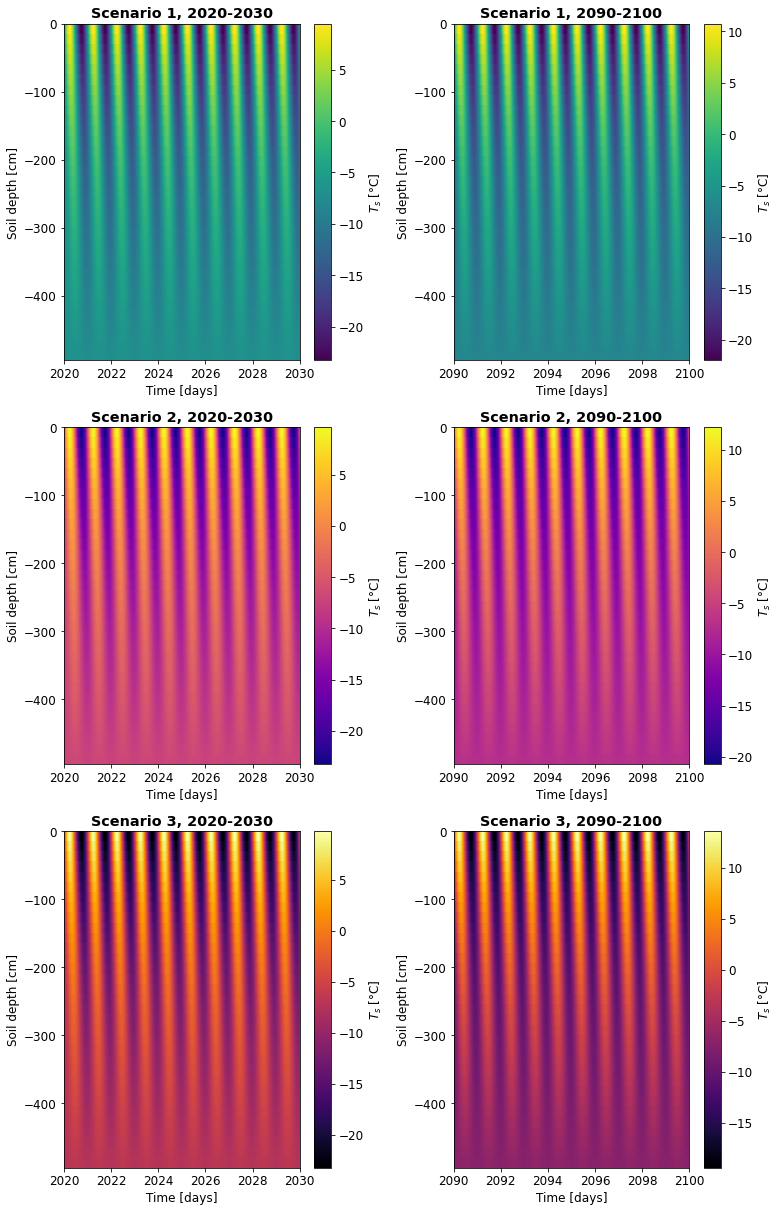

In [67]:
plt.figure(figsize=(11,17)) # 11" wide by 17" tall new figure
plt.rcParams.update({'font.size': 12}) # sets all font size for figures to 16

# delta T = 1.5 degrees C, first 10 years

t1,z1 = np.meshgrid(lim_2030,z) # create meshgrid of data for 2020-2030

plt.subplot(3,2,1)
plt.pcolormesh(t1,-z1,Ts_15[:,0:14601],cmap='viridis',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 1, 2020-2030',fontweight="bold")

plt.tight_layout() # change spacing between subplots

# Notice: plotting -z1 to have the top of the soil at the top
# negative value means into the land surface

# delta T = 1.5 degrees C, last 10 years

t2,z2 = np.meshgrid(lim_2090,z) # create meshgrid of data for 2090-2100

plt.subplot(3,2,2)
plt.pcolormesh(t2,-z2,Ts_15[:,102200:Nt+1],cmap='viridis',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 1, 2090-2100',fontweight="bold")

plt.tight_layout() # change spacing between subplots

# delta T = 3.0 degrees C, first 10 years

t1,z1 = np.meshgrid(lim_2030,z) # create meshgrid of data for 2020-2030

plt.subplot(3,2,3)
plt.pcolormesh(t1,-z1,Ts_30[:,0:14601],cmap='plasma',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 2, 2020-2030',fontweight="bold")

plt.tight_layout() # change spacing between subplots

# delta T = 3.0 degrees C, last 10 years

t2,z2 = np.meshgrid(lim_2090,z) # create meshgrid of data for 2090-2100

plt.subplot(3,2,4)
plt.pcolormesh(t2,-z2,Ts_30[:,102200:Nt+1],cmap='plasma',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 2, 2090-2100',fontweight="bold")

plt.tight_layout() # change spacing between subplots

# delta T = 4.5 degrees C, first 10 years

t1,z1 = np.meshgrid(lim_2030,z) # create meshgrid of data for 2020-2030

plt.subplot(3,2,5) 
plt.pcolormesh(t1,-z1,Ts_45[:,0:14601],cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 3, 2020-2030',fontweight="bold")

plt.tight_layout() # change spacing between subplots

# delta T = 4.5 degrees C, last 10 years

t2,z2 = np.meshgrid(lim_2090,z) # create meshgrid of data for 2090-2100

plt.subplot(3,2,6)
plt.pcolormesh(t2,-z2,Ts_45[:,102200:Nt+1],cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Scenario 3, 2090-2100',fontweight="bold")

plt.tight_layout() # change spacing between subplots

### 9.(2) Plots

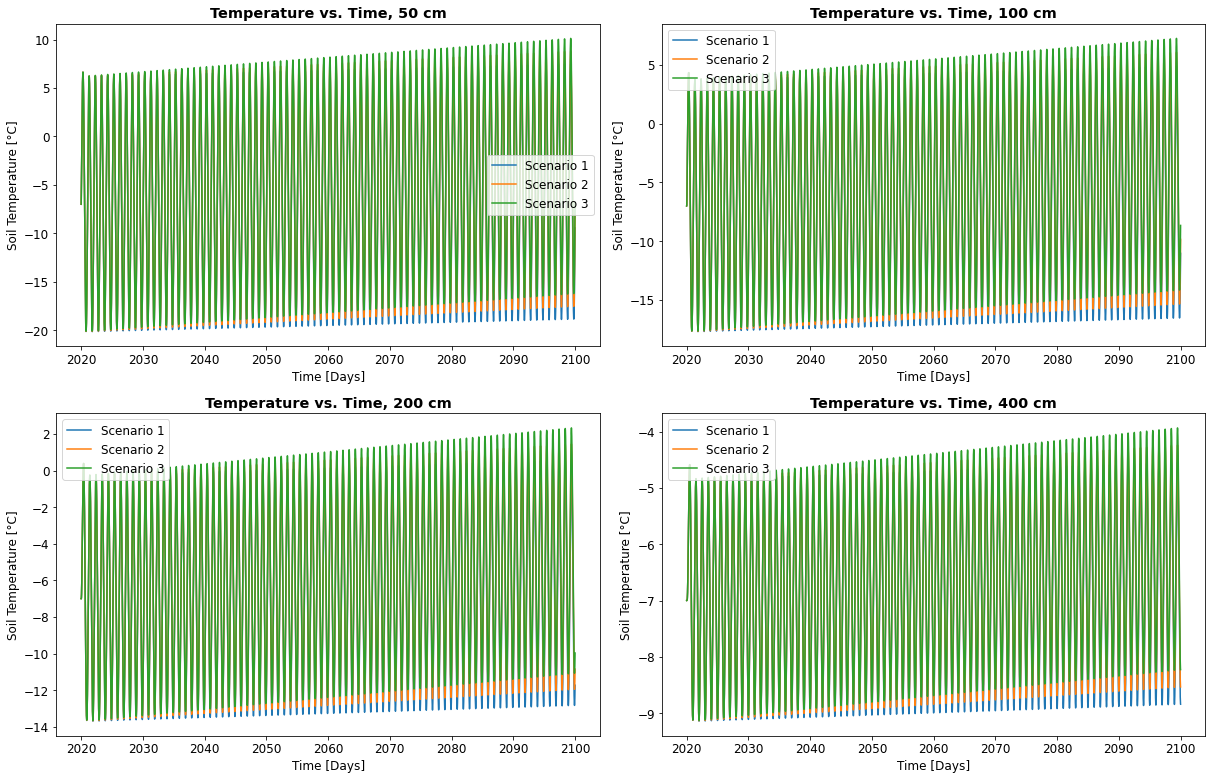

In [68]:
# plot temperature at four different depths of soil, 50, 100, 200, and 400 cm
# all scenarios on the same plot

plt.figure(figsize=(17,11)) # 17" wide by 11" tall new figure
plt.rcParams.update({'font.size': 12}) # sets all font size for figures to 16

# separate soil layers by depth of interest
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

# soil depth = 50 cm
plt.subplot(2,2,1)
plt.plot(t,Ts_15[iz50,:],label='Scenario 1')
plt.plot(t,Ts_30[iz50,:],label='Scenario 2')
plt.plot(t,Ts_45[iz50,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
plt.title('Temperature vs. Time, 50 cm',fontweight="bold")

# soil depth = 100 cm
plt.subplot(2,2,2)
plt.plot(t,Ts_15[iz100,:],label='Scenario 1')
plt.plot(t,Ts_30[iz100,:],label='Scenario 2')
plt.plot(t,Ts_45[iz100,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
plt.title('Temperature vs. Time, 100 cm',fontweight="bold")

# soil depth = 200 cm
plt.subplot(2,2,3)
plt.plot(t,Ts_15[iz200,:],label='Scenario 1')
plt.plot(t,Ts_30[iz200,:],label='Scenario 2')
plt.plot(t,Ts_45[iz200,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
plt.title('Temperature vs. Time, 200 cm',fontweight="bold")

# soil depth = 400 cm
plt.subplot(2,2,4)
plt.plot(t,Ts_15[iz400,:],label='Scenario 1')
plt.plot(t,Ts_30[iz400,:],label='Scenario 2')
plt.plot(t,Ts_45[iz400,:],label='Scenario 3')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
plt.title('Temperature vs. Time, 400 cm',fontweight="bold")

plt.tight_layout()

### 9.(3) Plots

<ipython-input-74-c8e5743548dc>:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  current_cmap_15.set_bad(color='blue')
<ipython-input-74-c8e5743548dc>:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  current_cmap_15.set_bad(color='blue')
<ipython-input-74-c8e5743548dc>:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap 

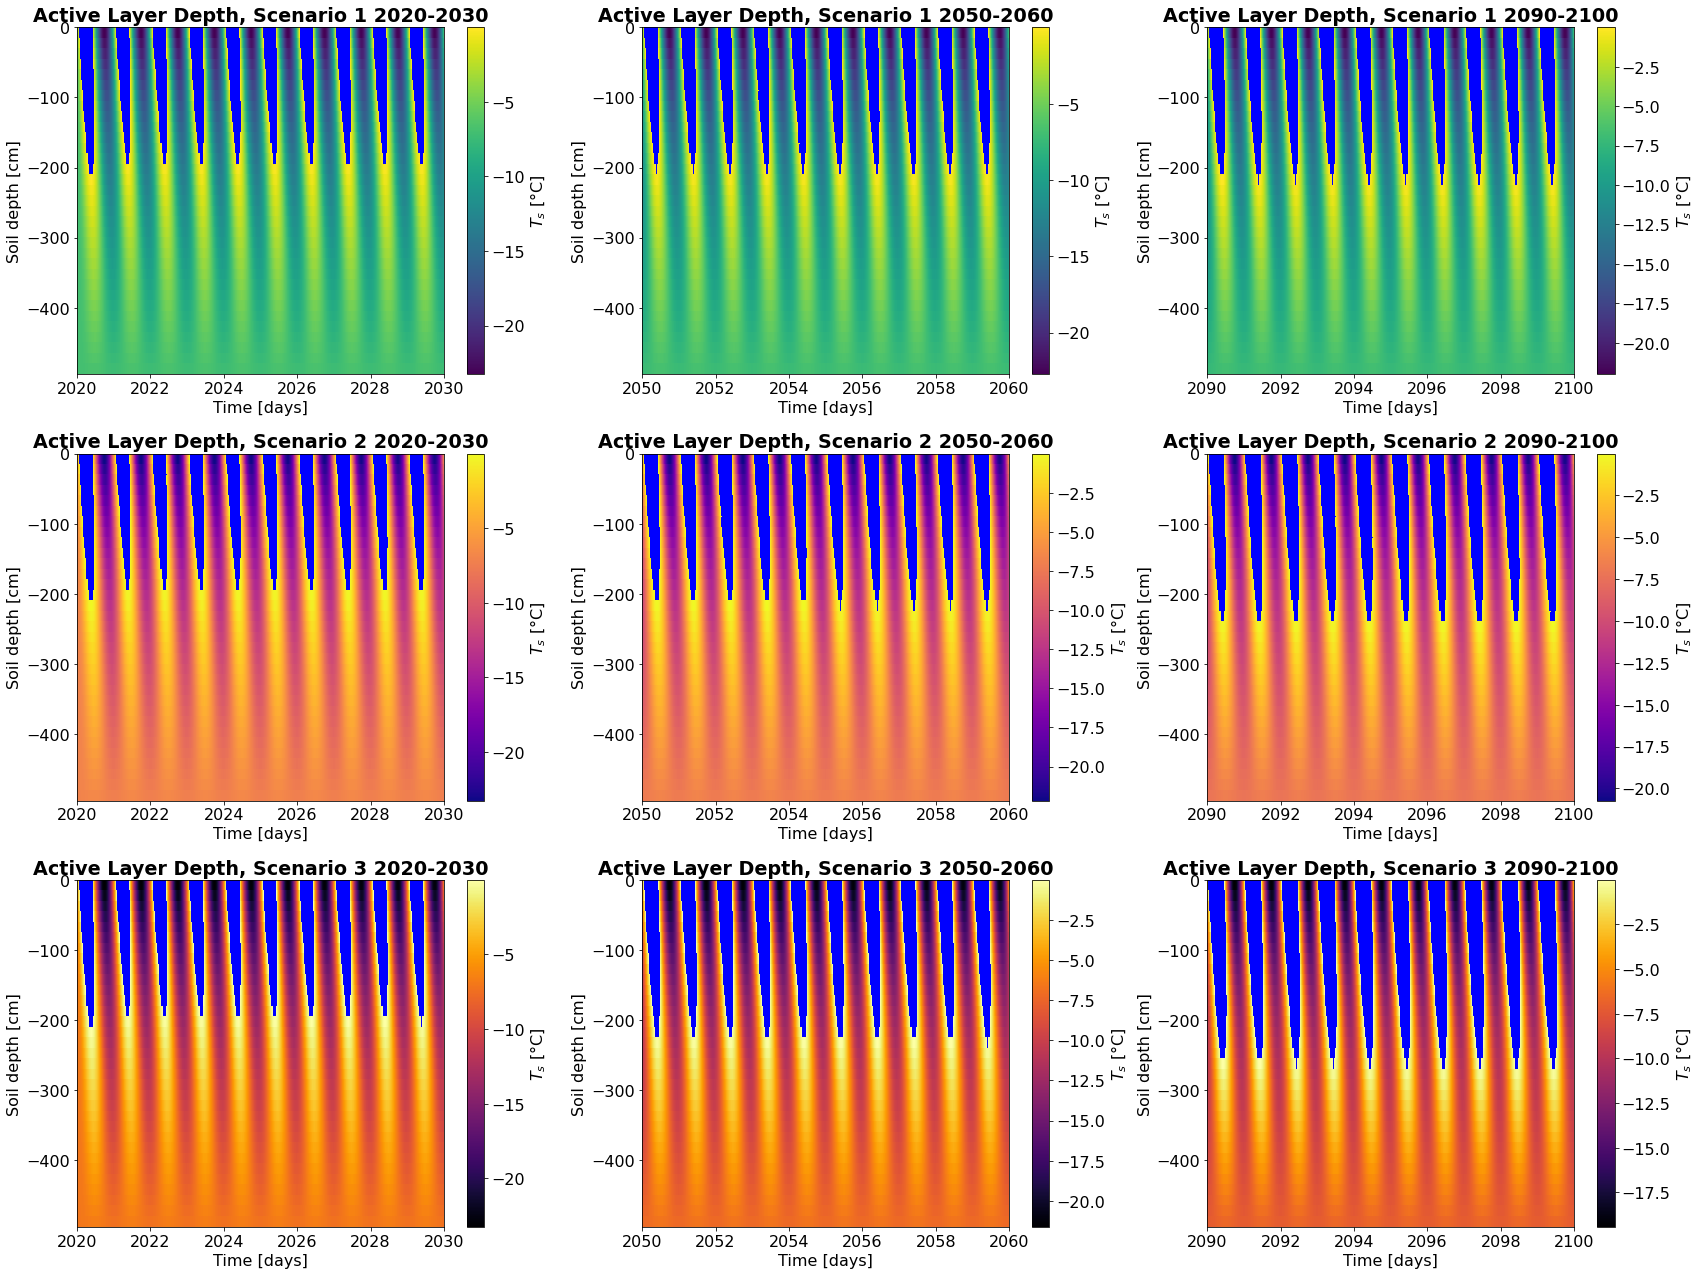

In [74]:
# highlight the active soil layers by masking temperatures at freezing

plt.figure(figsize=(24,18)) # 18" wide by 24" tall new figure
plt.rcParams.update({'font.size': 16}) # sets all font size for figures to 16
import copy
import matplotlib as mpl

t3,z3 = np.meshgrid(lim_2050_2060,z) # create meshgrid for data from 2050-2060

# mask where temperature is above 0 to show active layer
Ts_frozen_15 = np.ma.masked_where(Ts_15>0.0,Ts_15)
Ts_frozen_30 = np.ma.masked_where(Ts_30>0.0,Ts_30)
Ts_frozen_45 = np.ma.masked_where(Ts_45>0.0,Ts_45)

# 2020-2030, 1.5 C

plt.subplot(3,3,1)
current_cmap_15 = plt.cm.get_cmap('viridis')
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_15[:,0:14601],cmap=current_cmap_15,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 1 2020-2030',fontweight="bold")

# 2050-2060, 1.5 C

plt.subplot(3,3,2)
current_cmap_15 = plt.cm.get_cmap('viridis')
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_15[:,43800:58401],cmap=current_cmap_15,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 1 2050-2060',fontweight="bold")

# 2090-2100, 1.5 C

plt.subplot(3,3,3)
current_cmap_15 = plt.cm.get_cmap('viridis')
current_cmap_15.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_15[:,102200:Nt+1],cmap=current_cmap_15,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 1 2090-2100',fontweight="bold")

# 2020-2030, 3.0 C

plt.subplot(3,3,4)
current_cmap_30 = plt.cm.get_cmap('plasma')
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_30[:,0:14601],cmap=current_cmap_30,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 2 2020-2030',fontweight="bold")

# 2050-2060, 3.0 C

plt.subplot(3,3,5)
current_cmap_30 = plt.cm.get_cmap('plasma')
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_30[:,43800:58401],cmap=current_cmap_30,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 2 2050-2060',fontweight="bold")

# 2090-2100, 1.5 C

plt.subplot(3,3,6)
current_cmap_30 = plt.cm.get_cmap('plasma')
current_cmap_30.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_30[:,102200:Nt+1],cmap=current_cmap_30,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 2 2090-2100',fontweight="bold")

# 2020-2030, 4.5 C

plt.subplot(3,3,7)
current_cmap_45 = plt.cm.get_cmap('inferno')
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t1,-z1,Ts_frozen_45[:,0:14601],cmap=current_cmap_45,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 3 2020-2030',fontweight="bold")

# 2050-2060, 4.5 C

plt.subplot(3,3,8)
current_cmap_45 = plt.cm.get_cmap('inferno')
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t3,-z3,Ts_frozen_45[:,43800:58401],cmap=current_cmap_45,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 3 2050-2060',fontweight="bold")

# 2090-2100, 4.5 C

plt.subplot(3,3,9)
current_cmap_45 = plt.cm.get_cmap('inferno')
current_cmap_45.set_bad(color='blue')
plt.pcolormesh(t2,-z2,Ts_frozen_45[:,102200:Nt+1],cmap=current_cmap_45,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')
plt.title('Active Layer Depth, Scenario 3 2090-2100',fontweight="bold")

plt.tight_layout()

# can't figure out how to get rid of the below warning, even using the suggestion provided

### 9.(3) Markdown Table

|***Approximate Depth <br /> of Active Layer [cm]***|2020-2030|2050-2060|2090-2100|
|:-:|:-:|:-:|:-:|
|**ΔT = 1.5 ∘C**|  190   |  205   |  220   |
|**ΔT = 3.0 ∘C**|  190   |  210   |  230   |
|**ΔT = 4.5 ∘C**|  190   |  220   |  270   |